In [54]:
import numpy as np
from datetime import timedelta
import pandas as pd
from pandas.plotting import lag_plot, autocorrelation_plot
from datetime import date
import yaml

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib as mpl

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
import statsmodels.api as smw
from statsmodels.tsa.statespace.sarimax import SARIMAX

from scipy.signal import savgol_filter
import sklearn
from sklearn import preprocessing as pp
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.metrics import r2_score

import tensorflow as tf
from tensorflow import keras
from keras import optimizers, models, layers, regularizers
import keras_tuner as kt
tf.__version__

'2.6.0'

In [55]:
%load_ext skip_kernel_extension

The skip_kernel_extension extension is already loaded. To reload it, use:
  %reload_ext skip_kernel_extension


In [56]:
from utils.dde_preprocessing_utils import (set_timestamp_index,
remove_duplicates,
remove_columns,
extract_correlations,
prepare_data_sarimax,
create_test_train_split,
create_sarimax_test_train_split,
create_eval_df,
convert_to_sample_time_feature,
convert_from_differencing,
make_multiple_predictions,
calculate_r2_scores,
apply_differencing,
create_split,
apply_savgol_filter)
from utils.dde_plotting_utils import(
display_double_timestamps,
display_seasonal_decomposition,
plot_predictions,
plot_accuracy,
plot_error_variations,
plot_learning_curves,
plot_multiple_predictions,
plot_evaluation
)

In [57]:
config = tf.compat.v1.ConfigProto(gpu_options=tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8))
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)
mpl.rcParams['figure.figsize'] = [16.0, 8.0]
tf.random.set_seed(2022)

In [58]:
SKIP_RETRAIN_NN =True
SKIP_RETRAIN_RNN = True
SKIP_RETRAIN_LSTM = True
SKIP_RETRAIN_ED_LSTM = False

## Loading Data

In [59]:
with open('parameter.yaml','r') as f:
    parameter_dict = yaml.safe_load(f)
parameter_dict.keys()

dict_keys(['generation', 'share', 'time', 'weather'])

Benchmark data set

In [60]:
bench_df = pd.read_csv("energy_dataset.csv")
bench_df = set_timestamp_index(bench_df,"time")
bench_df = bench_df['price day ahead']
bench_df = bench_df.rename('Benchmark')

Base data set

In [61]:
base_df = pd.read_csv("extended_preprocessed_data3.csv")
base_df = set_timestamp_index(base_df,"Unnamed: 0")

In [62]:
base_df

,temp,pressure,humidity,wind_speed,wind_deg,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,...,share other renewable,share solar,share waste,share wind onshore,month,day,weekend,hour,energy_exchange_PT,energy_exchange_FR
2015-01-01 00:00:00+01:00,-2.675,1001.0,77,1.0,62,447.0,329.0,4844.0,4821.0,162.0,...,0.002584,0.001734,0.006938,0.225762,1,1,0,0,-285.0,933.0
2015-01-01 01:00:00+01:00,-2.675,1001.0,77,1.0,62,449.0,328.0,5196.0,4755.0,158.0,...,0.002552,0.001797,0.007010,0.211733,1,1,0,1,53.0,1119.0
2015-01-01 02:00:00+01:00,-3.464,1002.0,78,0.0,23,448.0,323.0,4857.0,4581.0,157.0,...,0.002724,0.001866,0.007315,0.203799,1,1,0,2,682.0,954.0
2015-01-01 03:00:00+01:00,-3.464,1002.0,78,0.0,23,438.0,254.0,4314.0,4131.0,160.0,...,0.002973,0.001982,0.007572,0.207668,1,1,0,3,976.0,13.0
2015-01-01 04:00:00+01:00,-3.464,1002.0,78,0.0,23,428.0,187.0,4130.0,3840.0,156.0,...,0.003006,0.001706,0.007677,0.200447,1,1,0,4,1011.0,-238.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00+01:00,12.490,1028.0,62,2.0,140,297.0,0.0,7634.0,2628.0,178.0,...,0.003596,0.003218,0.010486,0.117850,12,31,0,19,-1102.0,-3232.0
2018-12-31 20:00:00+01:00,9.990,1029.0,71,1.0,242,296.0,0.0,7241.0,2566.0,174.0,...,0.003768,0.001309,0.011105,0.130409,12,31,0,20,-1099.0,-3377.0
2018-12-31 21:00:00+01:00,8.510,1029.0,81,3.0,300,292.0,0.0,7025.0,2422.0,168.0,...,0.003919,0.001292,0.011923,0.146037,12,31,0,21,-1329.0,-3460.0
2018-12-31 22:00:00+01:00,6.990,1029.0,81,2.0,310,293.0,0.0,6562.0,2293.0,163.0,...,0.004088,0.001363,0.012616,0.157640,12,31,0,22,-937.0,-3429.0


Apply Savitzky Golay Filter 

In [63]:
savgol_df = apply_savgol_filter(base_df,5,1,excluded=parameter_dict['time'])

In [64]:
savgol_df

,temp,pressure,humidity,wind_speed,wind_deg,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,...,share other renewable,share solar,share waste,share wind onshore,energy_exchange_PT,energy_exchange_FR,month,day,weekend,hour
2015-01-01 00:00:00+01:00,-2.6750,1001.0,77.0,1.0,62.0,451.8,355.8,5130.2,4942.8,160.6,...,0.002515,0.001792,0.006894,0.220821,-215.6,1245.8,1,1,0,0
2015-01-01 01:00:00+01:00,-2.9117,1001.3,77.3,0.7,50.3,446.9,320.0,4899.2,4684.2,159.6,...,0.002641,0.001804,0.007098,0.215351,135.9,901.0,1,1,0,1
2015-01-01 02:00:00+01:00,-3.1484,1001.6,77.6,0.4,38.6,442.0,284.2,4668.2,4425.6,158.6,...,0.002768,0.001817,0.007302,0.209882,487.4,556.2,1,1,0,2
2015-01-01 03:00:00+01:00,-3.1850,1002.2,76.4,0.6,90.4,434.6,254.0,4507.0,4179.4,157.4,...,0.002862,0.001751,0.007466,0.202846,759.2,178.6,1,1,0,3
2015-01-01 04:00:00+01:00,-3.2216,1002.8,75.2,0.8,142.2,425.0,222.8,4275.8,3902.0,157.4,...,0.002971,0.001676,0.007622,0.197313,933.8,-297.2,1,1,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00+01:00,13.3980,1028.4,57.2,2.4,196.4,295.2,0.0,7277.0,2560.6,175.0,...,0.003762,0.014147,0.011411,0.123036,-871.0,-2831.8,12,31,0,19
2018-12-31 20:00:00+01:00,10.7960,1028.6,67.8,2.2,226.4,294.2,0.0,7211.0,2502.6,172.2,...,0.003795,0.003520,0.011490,0.133507,-1213.6,-2892.2,12,31,0,20
2018-12-31 21:00:00+01:00,8.7940,1028.8,74.0,2.0,258.4,293.6,0.0,7077.6,2415.0,169.2,...,0.003888,0.001711,0.011766,0.142690,-888.4,-3382.8,12,31,0,21
2018-12-31 22:00:00+01:00,7.1940,1029.0,77.6,2.1,297.2,291.9,0.0,6868.1,2295.3,165.1,...,0.004015,0.001347,0.012359,0.154146,-646.8,-3424.8,12,31,0,22


Apply Differencing 

In [65]:
diff_df = apply_differencing(savgol_df,excluded=parameter_dict['time']+parameter_dict['share'])
diff_df.index = diff_df.index.tz_convert('utc')
# diff_df = apply_savgol_filter(base_df,7,3,deriv=1,excluded=['month','day','weekend','hour'])

In [66]:
diff_df

,temp,pressure,humidity,wind_speed,wind_deg,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,...,share fossil oil,share hydro pumped storage,share hydro run-of-river and poundage,share hydro water reservoir,share nuclear,share other,share other renewable,share solar,share waste,share wind onshore
2015-01-01 00:00:00+00:00,-0.2367,0.3,0.3,-0.3,-11.7,-4.9,-35.8,-231.0,-258.6,-1.0,...,0.005804,0.036787,0.036787,0.058089,0.258123,0.001564,0.002641,0.001804,0.007098,0.215351
2015-01-01 01:00:00+00:00,-0.2367,0.3,0.3,-0.3,-11.7,-4.9,-35.8,-231.0,-258.6,-1.0,...,0.005991,0.048163,0.037224,0.047623,0.268173,0.001625,0.002768,0.001817,0.007302,0.209882
2015-01-01 02:00:00+00:00,-0.0366,0.6,-1.2,0.2,51.8,-7.4,-30.2,-161.2,-246.2,-1.2,...,0.006131,0.059461,0.037641,0.040312,0.276523,0.001675,0.002862,0.001751,0.007466,0.202846
2015-01-01 03:00:00+00:00,-0.0366,0.6,-1.2,0.2,51.8,-9.6,-31.2,-231.2,-277.4,0.0,...,0.006318,0.070496,0.038432,0.035491,0.284933,0.001726,0.002971,0.001676,0.007622,0.197313
2015-01-01 04:00:00+00:00,0.1212,0.4,-1.4,0.4,59.6,-8.0,-30.2,-165.4,-274.6,0.6,...,0.006512,0.079141,0.039560,0.033895,0.292535,0.001772,0.003041,0.001602,0.007772,0.190623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 18:00:00+00:00,-2.4980,0.2,12.0,0.0,20.0,-1.6,0.0,129.2,-16.2,-2.0,...,0.006984,0.001464,0.045304,0.144767,0.242519,0.002459,0.003762,0.014147,0.011411,0.123036
2018-12-31 19:00:00+00:00,-2.6020,0.2,10.6,-0.2,30.0,-1.0,0.0,-66.0,-58.0,-2.8,...,0.006956,0.001390,0.046237,0.140950,0.245790,0.002491,0.003795,0.003520,0.011490,0.133507
2018-12-31 20:00:00+00:00,-2.0020,0.2,6.2,-0.2,32.0,-0.6,0.0,-133.4,-87.6,-3.0,...,0.007004,0.002337,0.046838,0.124501,0.251984,0.002553,0.003888,0.001711,0.011766,0.142690
2018-12-31 21:00:00+00:00,-1.6000,0.2,3.6,0.1,38.8,-1.7,0.0,-209.5,-119.7,-4.1,...,0.007125,0.003756,0.048012,0.096302,0.262367,0.002638,0.004015,0.001347,0.012359,0.154146


In [67]:
diff_df.index = diff_df.index.tz_convert('utc')
base_df.index = base_df.index.tz_convert('utc')
bench_df.index = bench_df.index.tz_convert('utc')

# Encode- Decoder + LSTM

Scale the input data

In [68]:
scaled_df = diff_df.copy(deep=True)
featuresToScale = scaled_df.columns
sX = pp.MinMaxScaler(feature_range=(0,1),copy=True)
scaled_df.loc[:,featuresToScale] = sX.fit_transform(scaled_df[featuresToScale])

Create Train Validation Test Split

In [69]:
train_start = '2015-01-01'
validation_start = '2018-10-01'
test_start = '2018-11-01'
test_end = '2018-12-01'
feature = 'price actual'
namespace= 'MS_EDLSTM_Price9'
modeltype = 'EDLSTM'

batch_size = 64
num_epochs = 40

feature_df = diff_df[[feature]]

data_x_train0, data_y_train0 = create_split(scaled_df,feature_df,train_start,validation_start)
data_x_val0, data_y_val0 = create_split(scaled_df,feature_df,validation_start,test_start)
data_x_test0, data_y_test0 = create_split(scaled_df,feature_df,test_start,test_end)

Convert to (sample,timestep,feature) format

In [70]:
data_x_train,data_y_train,idx_train = convert_to_sample_time_feature(data_x_train0,data_y_train0,24*14,24,batch_size)
data_x_test,data_y_test,idx_test = convert_to_sample_time_feature(data_x_test0,data_y_test0,24*14,24,batch_size)
data_x_val,data_y_val,idx_val = convert_to_sample_time_feature(data_x_val0,data_y_val0,24*14,24,batch_size)


In [71]:
print(data_x_train.shape,data_y_train.shape,idx_train.shape)
print(data_x_val.shape,data_y_val.shape,idx_val.shape)
print(data_x_test.shape,data_y_test.shape,idx_test.shape)

(32448, 336, 44) (32448, 24) (32448,)
(320, 336, 44) (320, 24) (320,)
(320, 336, 44) (320, 24) (320,)


Define LSTM Model

In [72]:
def build_model_ED_LSTM():
    n_timesteps, n_features, n_outputs = data_x_train.shape[1], data_x_train.shape[2], data_y_train.shape[1]
    model = models.Sequential()
    # Encoder
    model.add(layers.LSTM(90, return_sequences=True,input_shape=(None, n_features), stateful=False))
    model.add(layers.BatchNormalization())
    
    model.add(layers.Bidirectional(layers.LSTM(90, return_sequences=True, stateful=False))) 
    model.add(layers.BatchNormalization())  
    
    model.add(layers.LSTM(90, return_sequences=False, stateful=False)) 
    model.add(layers.BatchNormalization())  
    
    # Repeat Vector
    model.add(layers.RepeatVector(n_outputs))
    
    # Decoder
    model.add(layers.Bidirectional(layers.LSTM(90, return_sequences=True,stateful=False)))
    model.add(layers.BatchNormalization())
    model.add(layers.Bidirectional(layers.LSTM(90, return_sequences=True,stateful=False)))
    model.add(layers.BatchNormalization())

    # End
    model.add(layers.TimeDistributed(layers.Dense(90, kernel_regularizer=regularizers.l2(0.001), kernel_initializer="he_normal")))
    model.add(layers.TimeDistributed(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), kernel_initializer="he_normal")))
    
    model.add(layers.TimeDistributed(layers.LeakyReLU(alpha=0.1)))                     
    model.add(layers.TimeDistributed(layers.BatchNormalization()))
    model.add(layers.TimeDistributed(layers.Dense(1)))                     
                
    model.compile(optimizer='Adam',loss='mse',metrics='mae') 
    return model

In [73]:
myCheckpointLSTM= keras.callbacks.ModelCheckpoint(f"./{modeltype}/my_best_model_{namespace}.h5", save_best_only=True)
myEarly_stoppingLSTM = keras.callbacks.EarlyStopping(patience=20,restore_best_weights=True)

In [74]:
initial_learning_rate = 0.001

decay = initial_learning_rate/num_epochs

def scheduler(epoch,lr):
    return lr*1/(1+decay*epoch)

myLearningRate_LSTM = keras.callbacks.LearningRateScheduler(scheduler, verbose=1)


In [75]:
%%skip $SKIP_RETRAIN_ED_LSTM
model_ED_LSTM= build_model_ED_LSTM()
history_ED_LSTM = model_ED_LSTM.fit(data_x_train, data_y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(data_x_val, data_y_val) , 
                                 callbacks=[myCheckpointLSTM,myEarly_stoppingLSTM,myLearningRate_LSTM])#

Epoch 1/40

Epoch 00001: LearningRateScheduler setting learning rate to 0.0010000000474974513.
507/507 [==============================] - 58s 104ms/step - loss: 3.7501 - mae: 1.3806 - val_loss: 2.3321 - val_mae: 1.1404
Epoch 2/40

Epoch 00002: LearningRateScheduler setting learning rate to 0.0009999750481212483.
507/507 [==============================] - 51s 100ms/step - loss: 1.6652 - mae: 0.8845 - val_loss: 1.5669 - val_mae: 0.9161
Epoch 3/40

Epoch 00003: LearningRateScheduler setting learning rate to 0.0009999250219521608.
507/507 [==============================] - 51s 100ms/step - loss: 1.3810 - mae: 0.8065 - val_loss: 5.6978 - val_mae: 1.9013
Epoch 4/40

Epoch 00004: LearningRateScheduler setting learning rate to 0.0009998500872736493.
507/507 [==============================] - 51s 100ms/step - loss: 1.2290 - mae: 0.7693 - val_loss: 1.1487 - val_mae: 0.7824
Epoch 5/40

Epoch 00005: LearningRateScheduler setting learning rate to 0.0009997501295499831.
507/507 [====================

In [76]:
%%skip $SKIP_RETRAIN_ED_LSTM
histEDLSTM = pd.DataFrame(history_ED_LSTM.history)
histEDLSTM['epoch'] = history_ED_LSTM.epoch

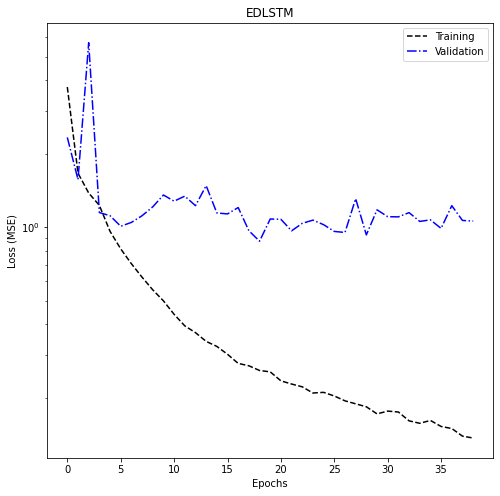

In [77]:
%%skip $SKIP_RETRAIN_ED_LSTM
fig = plot_learning_curves(histEDLSTM,modeltype,f"./{modeltype}/learningcurve_{namespace}.png")

Load best model

In [78]:
model_best_ED_LSTM = keras.models.load_model(f"./{modeltype}/my_best_model_{namespace}.h5")
model_best_ED_LSTM.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, None, 90)          48600     
_________________________________________________________________
batch_normalization_6 (Batch (None, None, 90)          360       
_________________________________________________________________
bidirectional_3 (Bidirection (None, None, 180)         130320    
_________________________________________________________________
batch_normalization_7 (Batch (None, None, 180)         720       
_________________________________________________________________
lstm_7 (LSTM)                (None, 90)                97560     
_________________________________________________________________
batch_normalization_8 (Batch (None, 90)                360       
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 24, 90)           

Evaluate differencing performance on validation data

In [79]:
i=0
case_val = data_x_val[i].reshape((1,data_x_val[0].shape[0], data_x_val[0].shape[1]))
Y_val_predictions_diff = pd.Series(model_best_ED_LSTM.predict(case_val).flatten(),index=pd.date_range(start=idx_val[i],freq='h',periods=24))
y_val_filtered_diff = data_y_val0.loc[Y_val_predictions_diff.index]
y_val_filtered_diff = y_val_filtered_diff.squeeze(axis=1)

In [80]:
eval_df_diff = create_eval_df(Y_val_predictions_diff,y_val_filtered_diff)

R^2 score is  0.87


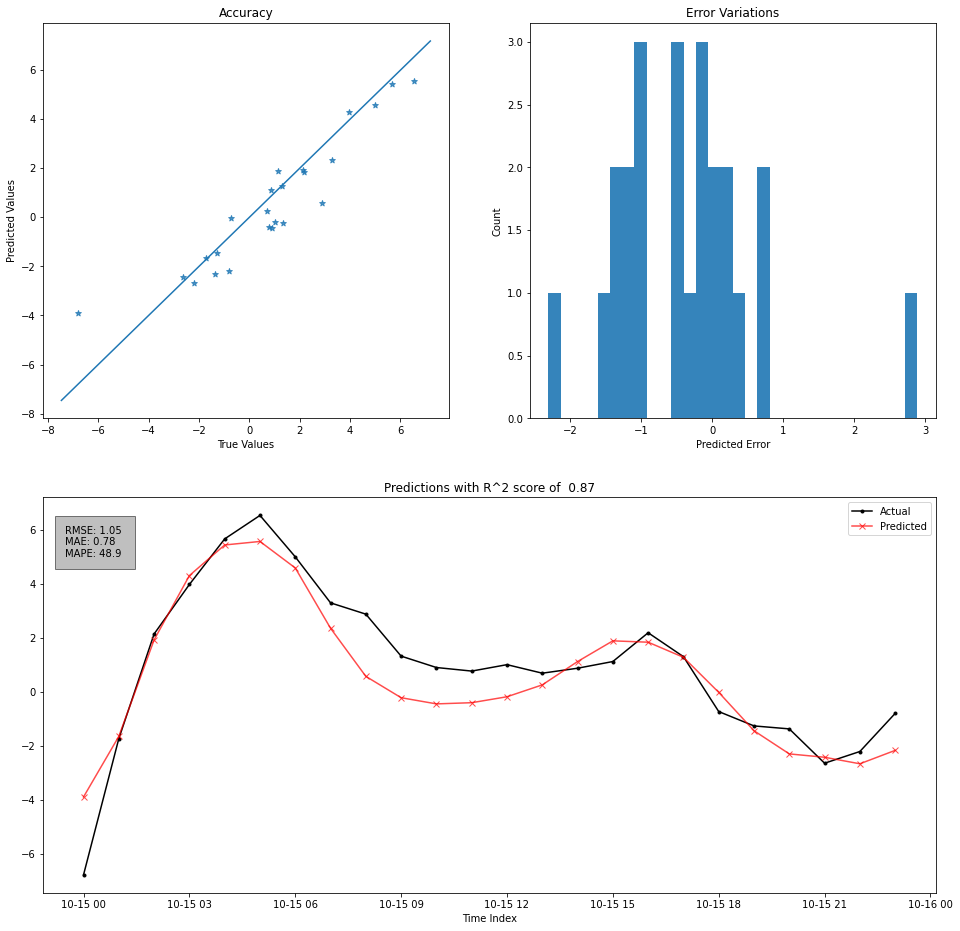

In [81]:
fig = plot_evaluation(eval_df_diff)

In [82]:
df_pred_diff = make_multiple_predictions(model_best_ED_LSTM,idx_val,data_x_val,data_y_val0,feature,convert=False)

In [83]:
eval_df_diff = create_eval_df(df_pred_diff['mean'],df_pred_diff['Actual'])

R^2 score is  0.84


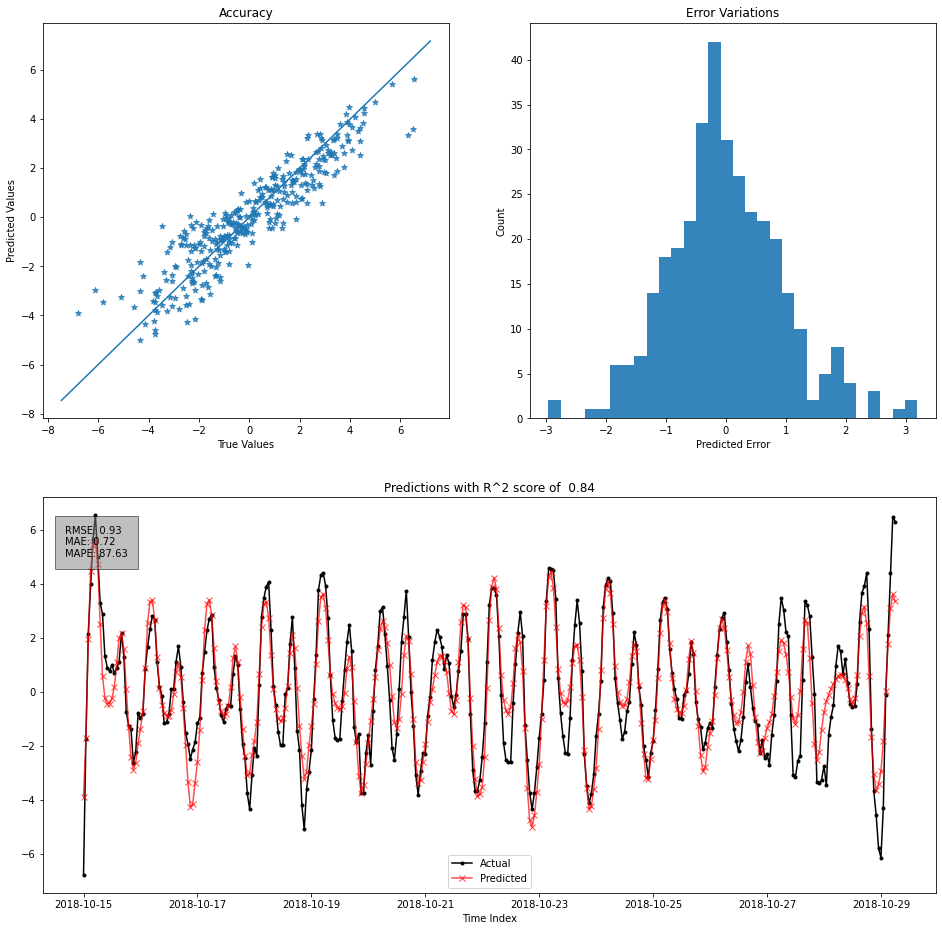

In [84]:
fig = plot_evaluation(eval_df_diff)

Reverting differencing on validation data

In [85]:
df_pred = make_multiple_predictions(model_best_ED_LSTM,idx_val,data_x_val,savgol_df,feature,convert=True)

In [86]:
eval_df = create_eval_df(df_pred['mean'],df_pred['Actual'])

R^2 score is  0.82


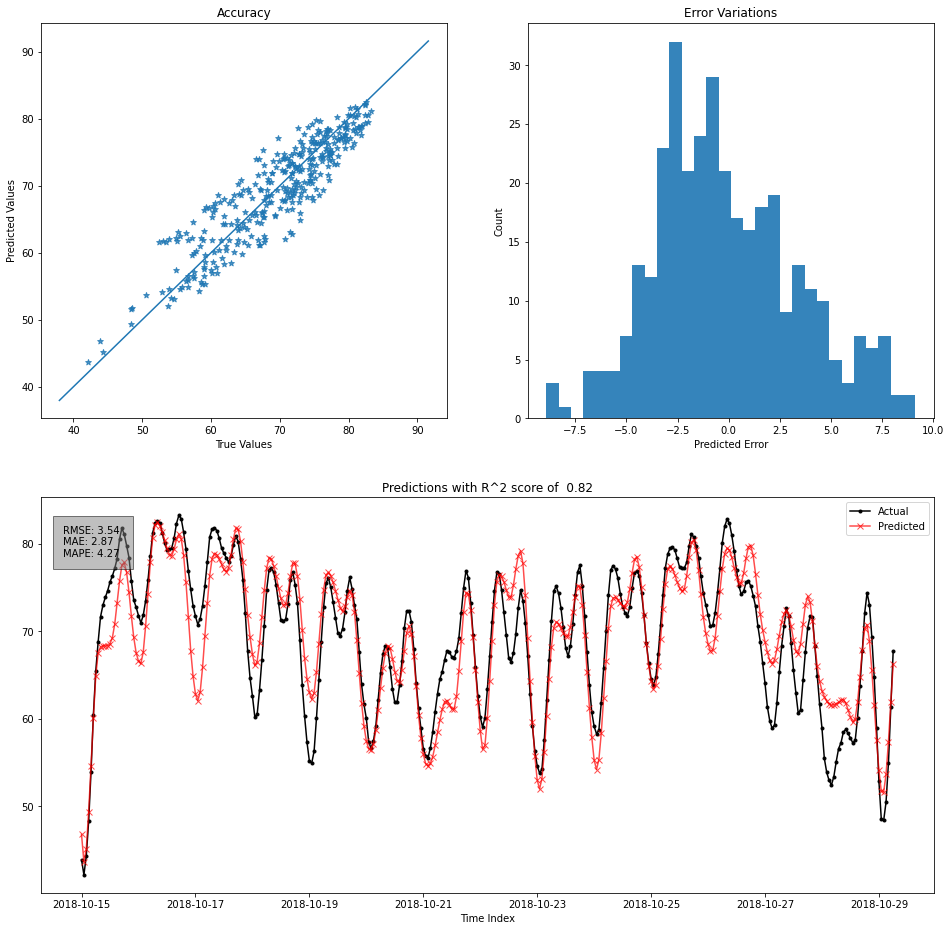

In [87]:
fig = plot_evaluation(eval_df)

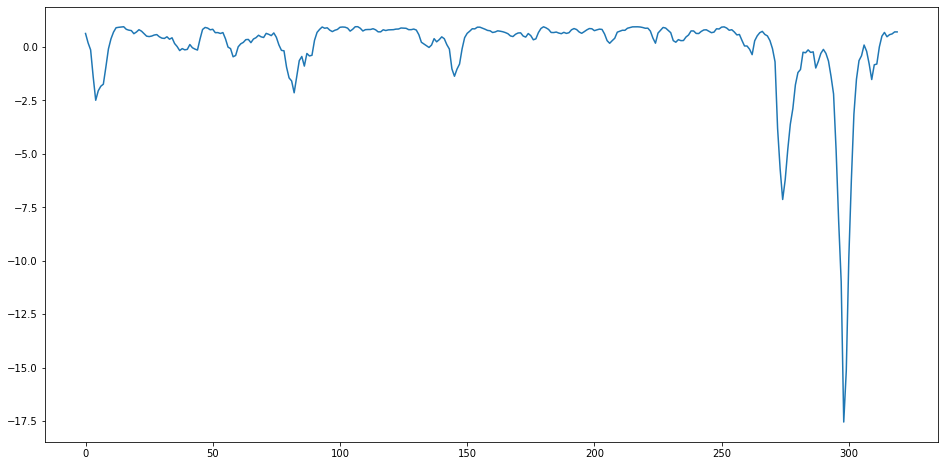

In [88]:
r2 = calculate_r2_scores(df_pred)
plt.figure()
plt.plot(r2)


Evaluate differencing Performance on test data

In [89]:
i=0
case_test = data_x_test[i].reshape((1,data_x_test[0].shape[0], data_x_test[0].shape[1]))
Y_test_predictions_diff = pd.Series(model_best_ED_LSTM.predict(case_test).flatten(),index=pd.date_range(start=idx_test[i],freq='h',periods=24))
y_test_filtered_diff = data_y_test0.loc[Y_test_predictions_diff.index]
y_test_filtered_diff = y_test_filtered_diff.squeeze(axis=1)

In [90]:
eval_df_diff = create_eval_df(Y_test_predictions_diff,y_test_filtered_diff)

R^2 score is  0.86


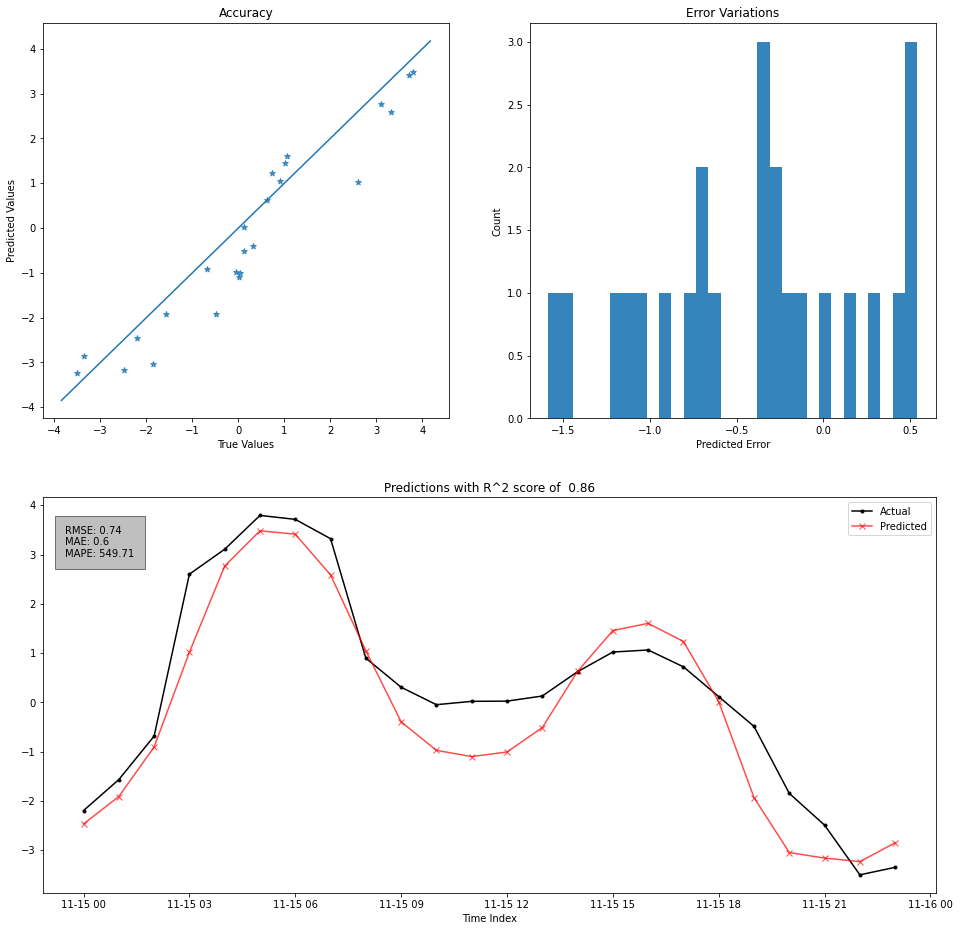

In [91]:
fig = plot_evaluation(eval_df_diff)

In [92]:
df_pred_diff = make_multiple_predictions(model_best_ED_LSTM,idx_test,data_x_test,data_y_test0,feature,convert=False)

In [93]:
eval_df_diff = create_eval_df(df_pred_diff['mean'],df_pred_diff['Actual'])

R^2 score is  0.88


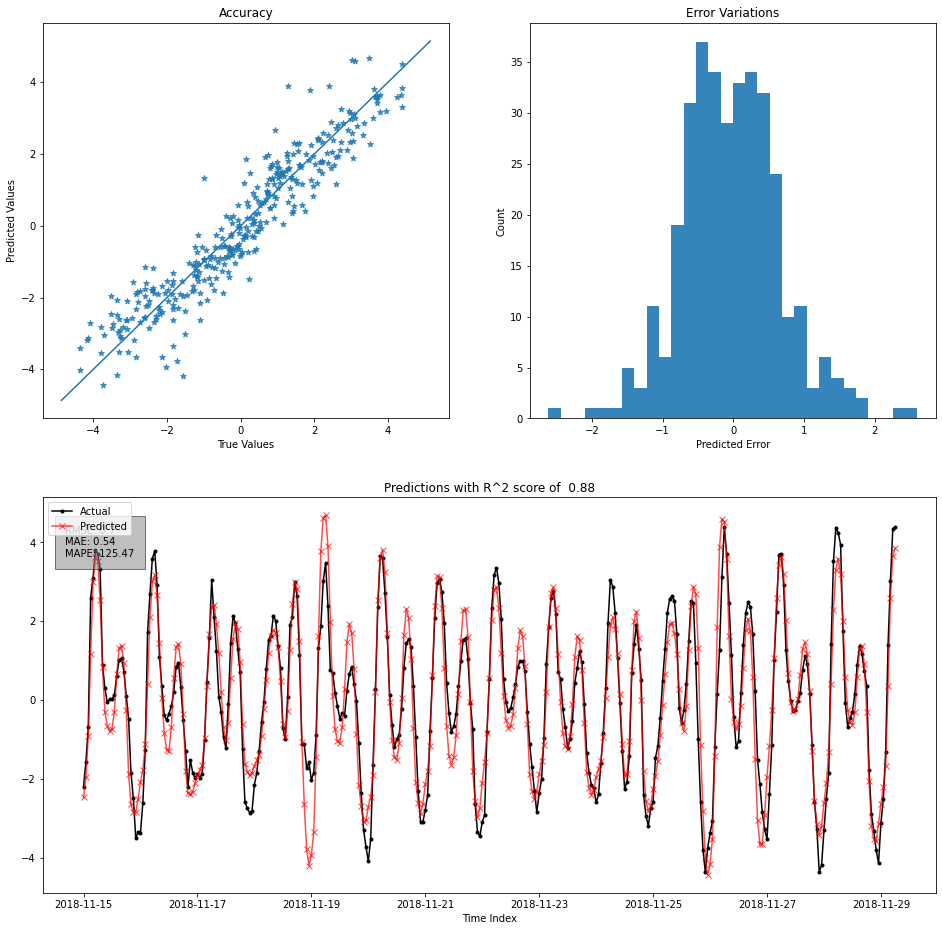

In [94]:
fig = plot_evaluation(eval_df_diff)

Reverting differencing on test data

In [95]:
df_pred = make_multiple_predictions(model_best_ED_LSTM,idx_test,data_x_test,savgol_df,feature,convert=True)

In [96]:
eval_df = create_eval_df(df_pred['mean'],df_pred['Actual'])

R^2 score is  0.84


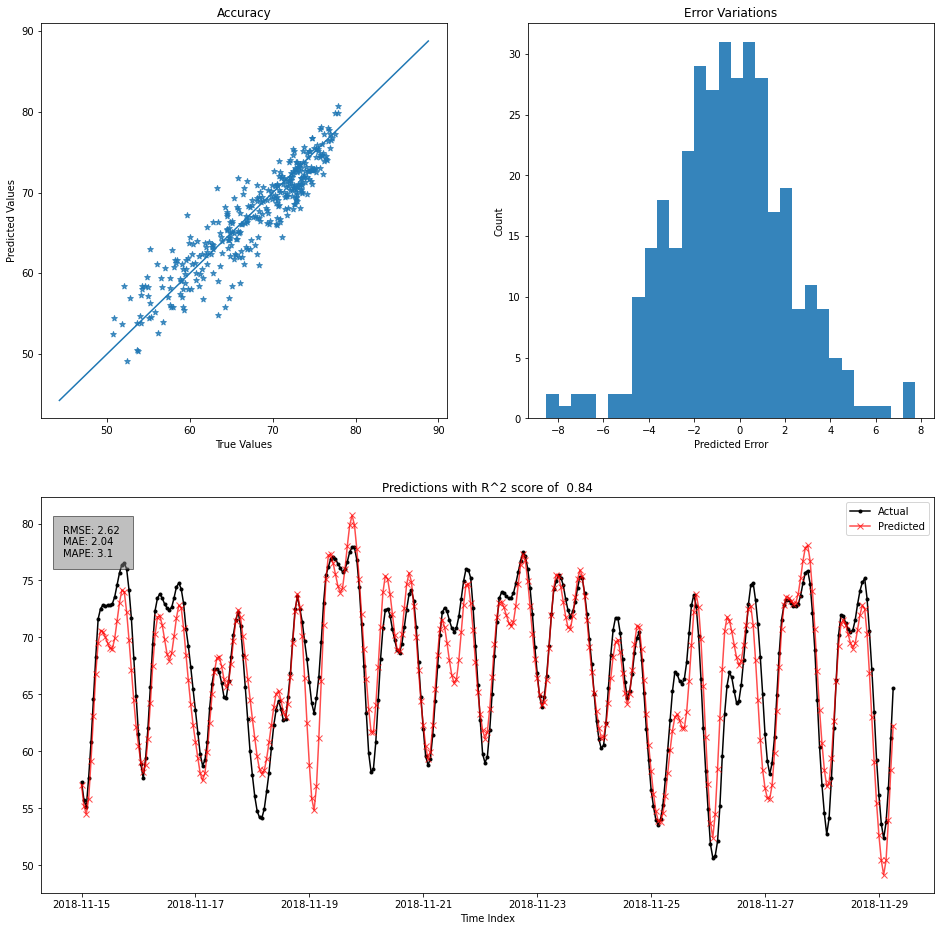

In [97]:
fig = plot_evaluation(eval_df)

In [98]:
def calculate_metrics(df_pred):
    r2_list=[]
    mpe_list= []
    mae_list= []
    for column in df_pred.columns:
        if column not in ['Actual','mean']:
            pred = df_pred[column].dropna()
            act = df_pred.loc[pred.index,'Actual']
            r2= r2_score(pred,act)
            mpe = (act-pred)/act
        
            mae = sklearn.metrics.mean_absolute_error(act,pred)
            r2_list.append(r2)
            mpe_list.append(mpe.mean())
            mae_list.append(mae)
    return r2_list,mpe_list,mae_list      

def plot_metrics(df_pred):
    fig= plt.figure(figsize = (16,16))
    gs = fig.add_gridspec(3,1)
    r2_list,mpe_list,mae_list = calculate_metrics(df_pred)
    ax1 = fig.add_subplot(gs[0,0],)
    ax2 = fig.add_subplot(gs[1,0],sharex=ax1)
    ax3 = fig.add_subplot(gs[2,0],sharex=ax1)
    ax1.plot(r2_list)
    ax1.set_title('R2 Score')
    ax2.plot(mpe_list)
    ax2.set_title('RMSE')
    ax3.plot(mae_list)
    ax3.set_title('MAE')
    ax1.set_xticks(ticks=range(0,len(r2_list),24))
    return fig


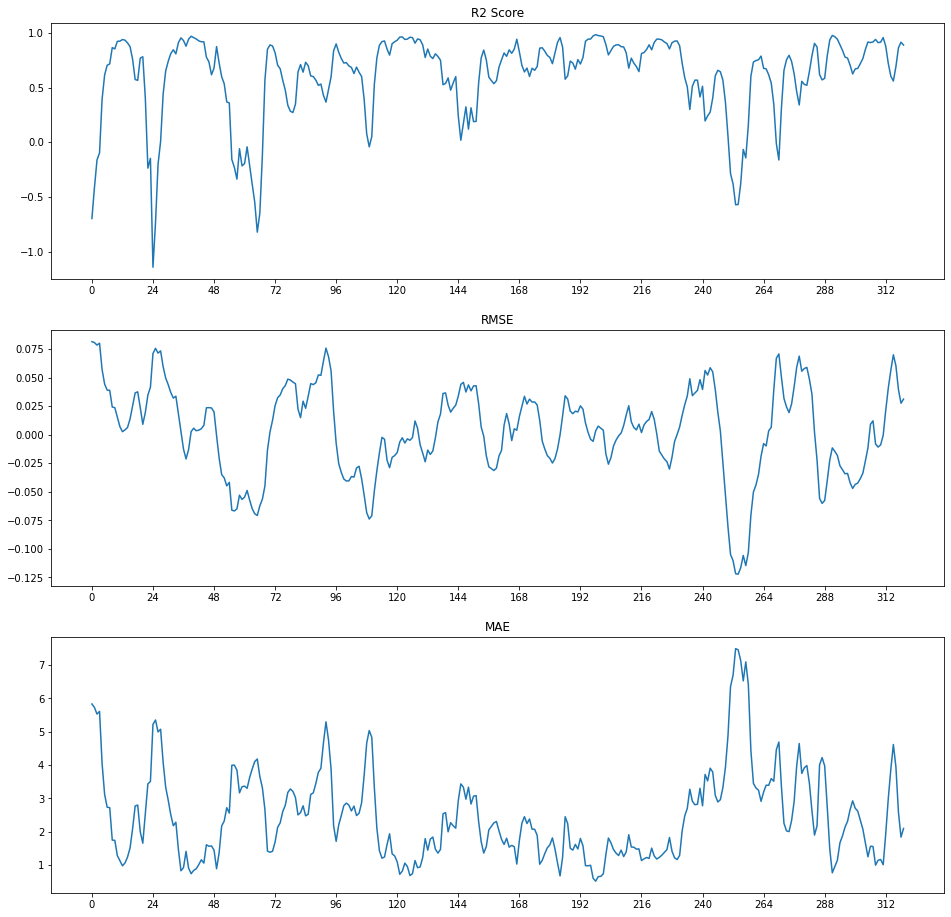

In [99]:
fig = plot_metrics(df_pred)

In [100]:
eval_df

,Prediction,Actual
2018-11-15 00:00:00+00:00,57.064662,57.336
2018-11-15 01:00:00+00:00,55.243741,55.770
2018-11-15 02:00:00+00:00,54.513348,55.086
2018-11-15 03:00:00+00:00,55.822288,57.688
2018-11-15 04:00:00+00:00,59.189025,60.796
...,...,...
2018-11-29 02:00:00+00:00,49.168901,52.358
2018-11-29 03:00:00+00:00,50.432616,53.764
2018-11-29 04:00:00+00:00,53.972557,56.792
2018-11-29 05:00:00+00:00,58.369985,61.136


Comparing to Benchmark

In [101]:
def extend_eval_df_benchmark(eval_df,bench_df):
    bench_df=bench_df[eval_df.index]
    extended_eval_df = pd.concat([eval_df,bench_df],axis=1)
    return extended_eval_df

In [102]:
extended_eval_df = extend_eval_df_benchmark(eval_df,bench_df)
extended_eval_df

,Prediction,Actual,Benchmark
2018-11-15 00:00:00+00:00,57.064662,57.336,51.95
2018-11-15 01:00:00+00:00,55.243741,55.770,51.27
2018-11-15 02:00:00+00:00,54.513348,55.086,50.29
2018-11-15 03:00:00+00:00,55.822288,57.688,51.03
2018-11-15 04:00:00+00:00,59.189025,60.796,53.17
...,...,...,...
2018-11-29 02:00:00+00:00,49.168901,52.358,47.00
2018-11-29 03:00:00+00:00,50.432616,53.764,46.67
2018-11-29 04:00:00+00:00,53.972557,56.792,49.64
2018-11-29 05:00:00+00:00,58.369985,61.136,58.33


In [103]:
r2_bench = r2_score(extended_eval_df['Actual'],extended_eval_df['Benchmark'],)
print('R^2 score is  %3.2f' %r2_bench)

R^2 score is  0.44


In [104]:
r2_test = r2_score(extended_eval_df['Actual'], extended_eval_df['Prediction'])
print('R^2 score is  %3.2f' %r2_test)

R^2 score is  0.84


In [105]:
df_pred_24h = df_pred.iloc[:,0::24]
df_pred_24h['total'] = df_pred_24h.mean(axis=1)


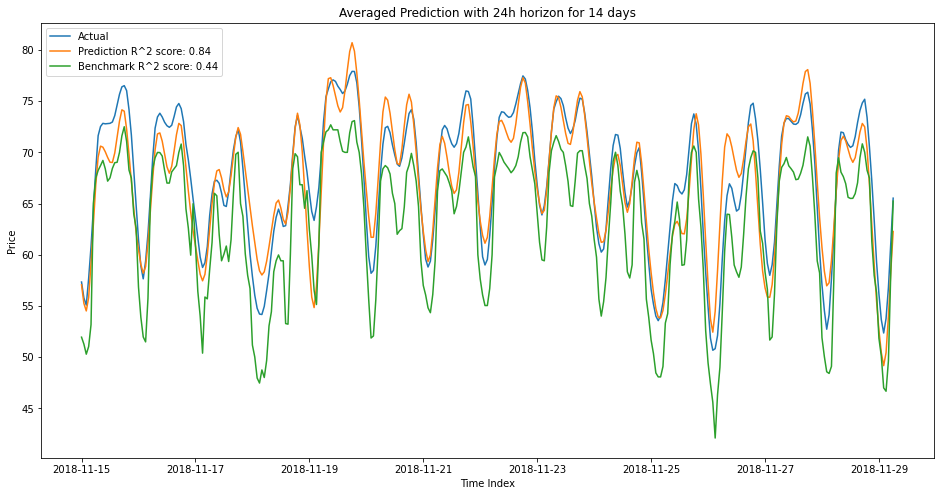

In [106]:
fig = plt.figure(figsize=(16,8))
plt.plot(extended_eval_df['Actual'],label = 'Actual')
plt.plot(extended_eval_df['Prediction'], label= f'Prediction R^2 score: {round(r2_test,2)}')
plt.plot(extended_eval_df['Benchmark'], label = f'Benchmark R^2 score: {round(r2_bench,2)}')
plt.xlabel('Time Index')
plt.ylabel('Price')
plt.title('Averaged Prediction with 24h horizon for 14 days')
plt.legend()
# plt.xlim(idx_test[0],idx_test[0]+timedelta(hours=24*14-1))